In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['POLARS_MAX_THREADS'] = '1'
import polars as pl
from polars import DataFrame
import numpy as np

In [3]:
seed = 100
np.random.seed(seed)

In [4]:
def gen_rows(count: int):
    width = 3
    return [
        np.random.choice(['a', 'b', 'c', 'd', 'e', 'f', 'g'], count),
        np.random.randint(0, 33, (count, width), dtype=np.int32),
    ]


def load_large_df(data) -> pl.DataFrame:
    df = DataFrame(data, schema=["name", "indices"])
    df = df.with_columns([pl.col("indices").cast(pl.List(pl.Int32))])
    return df


def queries(db: DataFrame, queries: list[str]) -> list[set[int]]:
    nodes_so_far = db.filter(pl.col("name") == queries[0])["indices"].to_list()[0]
    for q in queries[1:]:
        found_nodes = db.filter(
            (pl.col("name") == q)
            & (pl.col("indices").list.set_intersection(list(nodes_so_far)).list.len() == 1)
        )
        nodes_so_far = set(found_nodes["indices"].to_list()[0]).union(nodes_so_far)
    return nodes_so_far



In [5]:
data = gen_rows(1_000_000)

In [8]:
%%timeit
df = load_large_df(data)


76.4 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
queries(df,
        ["a", "b", "c", "a", "e", "f", "g", "g", "f", "c", "b", "a", "d", "f", "e", "d", "c", "b", "a", "f", "e", "d",
         "c", "b", "a"])


910 ms ± 6.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


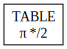

In [16]:
qq = df.filter(
    (pl.col("name") == 'a')
    & (pl.col("indices").list.set_intersection([0, 2, 3]).list.len() == 1)
).lazy()
qq.show_graph(optimized=False)